#### 1.- Implementación de una estrategia sencilla y backtest

##### 1.1.- Importación de las librerias

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from ib_insync import *
util.startLoop()

##### 1.2.- Estableciendo conexión con la API TWS de Interactive Brokers

IMPORTANTE: antes de establecer la conexión hay que bajar el software [Trader Workstation (TWS)](https://www.ibkrguides.com/traderworkstation/getting-started.htm) de Interactive Brokers, configurarlo correctamente y tenerlo corriendo. Para ello hay que seguir el [manual](../../0.%20Instalación%20de%20Anaconda%20y%20la%20TWS.pdf).

In [4]:
# Crea un objeto IB
ib = IB()
# se conecta a IB
ib.connect('127.0.0.1', 7497, clientId = 11)
# La API de InteractiveBrokers permite conectarse a una instancia de la TWS (Trader WorkStation) 
# o IB Gateway usando hasta 32 clients.
# Puertos: Paper Trading 7497 | Live trading 7496.

<IB connected to 127.0.0.1:7497 clientId=11>

##### 1.2.- Solicitud de datos historicos

In [5]:
# Parámetros del activo
Contract = Forex('EURUSD')
Compresion = '1 min' # Formato válidos: '1 min', '2 mins'. Formatos inválidos '1 mins','5 min'. Respetar los espacios.

# La función reqHistoricalData() nos permite solicictar datos históricos.
bars = ib.reqHistoricalData(
    Contract,
    endDateTime='',
    durationStr='10 D',
    barSizeSetting=Compresion,
    whatToShow='BID_ASK',
    useRTH=True,
    formatDate=1)

# Almacena los datos históricos en un DataFrame
df = util.df(bars)
# Renombra las columnas
df.rename(columns = {'date':'Time','open':'Open','high':'High','low':'Low','close':'Close'}, inplace = True)
# Asigna el índice 
df.set_index('Time', inplace=True)
# Nos quedamos solo con las columnas Open, High, Low y Close
df = df[['Open','High','Low','Close']]

# print('*'*55)
# print('Primeras 5 filas de nuestro DataFrame')
# print('*'*55)
# print(df.head())
# print('*'*55)

# print('Últimas 5 filas de nuestro DataFrame')
# print('*'*55)
# print(df.tail())

Text(0, 0.5, 'Precio')

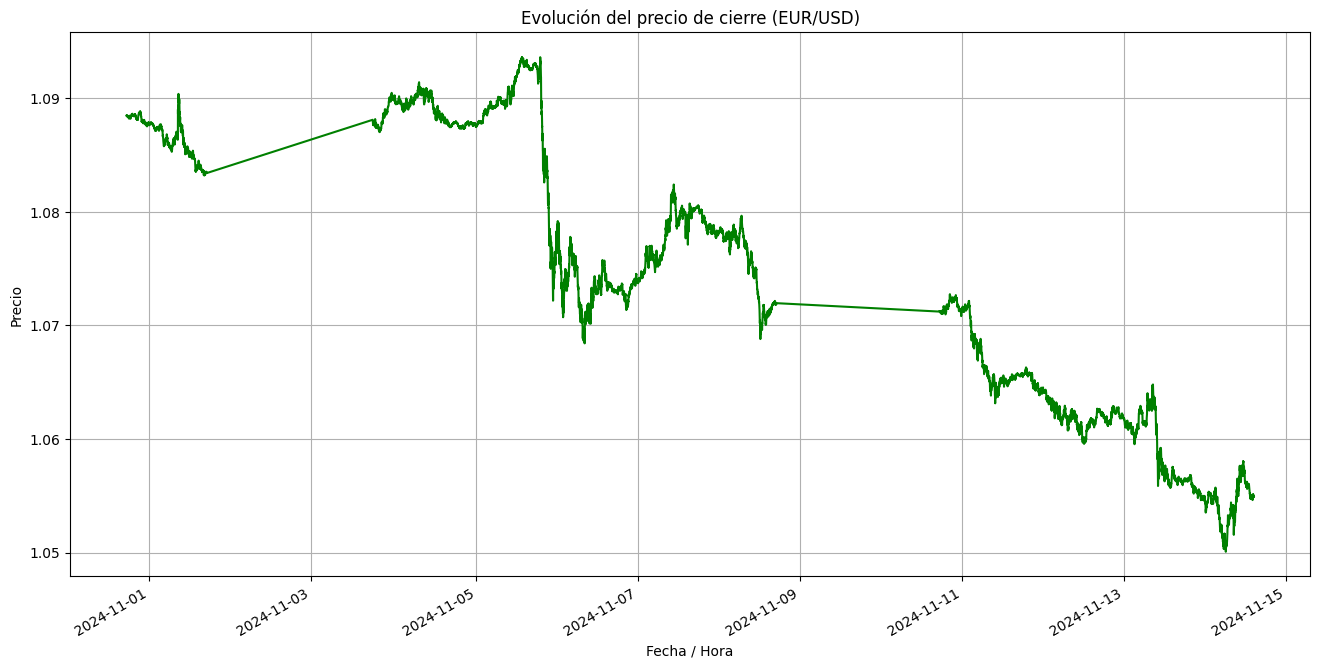

In [6]:
# Crea un gráfico y muesta la evolución del precio de cierre.
df['Close'].plot(grid = True,
                 title ='Evolución del precio de cierre (EUR/USD)',
                 color='green',
                 figsize =(16,8))

# Establece valores para las etiquetas de los ejes X e Y.
plt.xlabel('Fecha / Hora')
plt.ylabel('Precio')

##### 1.4.- Calculo de las SMAs





In [7]:
df['SMA50'] = ta.sma(df["Close"], length=50)
df['SMA200'] = ta.sma(df["Close"], length=200)

df['EMA50'] = ta.ema(df["Close"], length=50)
df['EMA200'] = ta.ema(df["Close"], length=200)


In [16]:
# df[['SMA50','SMA200','Close']][-1000:].plot(grid =True,  
#                                               title ='Precio & Medias Móviles Simples',                             
#                                               figsize =(16,8))
# plt.xlabel('Fecha / Hora')
# plt.ylabel('Precio')

# df[['EMA50','EMA200','Close']][-1000:].plot(grid =True,  
#                                               title ='Precio & Medias Móviles Exponenciales',                             
#                                               figsize =(16,8))
# plt.xlabel('Fecha / Hora')
# plt.ylabel('Precio')

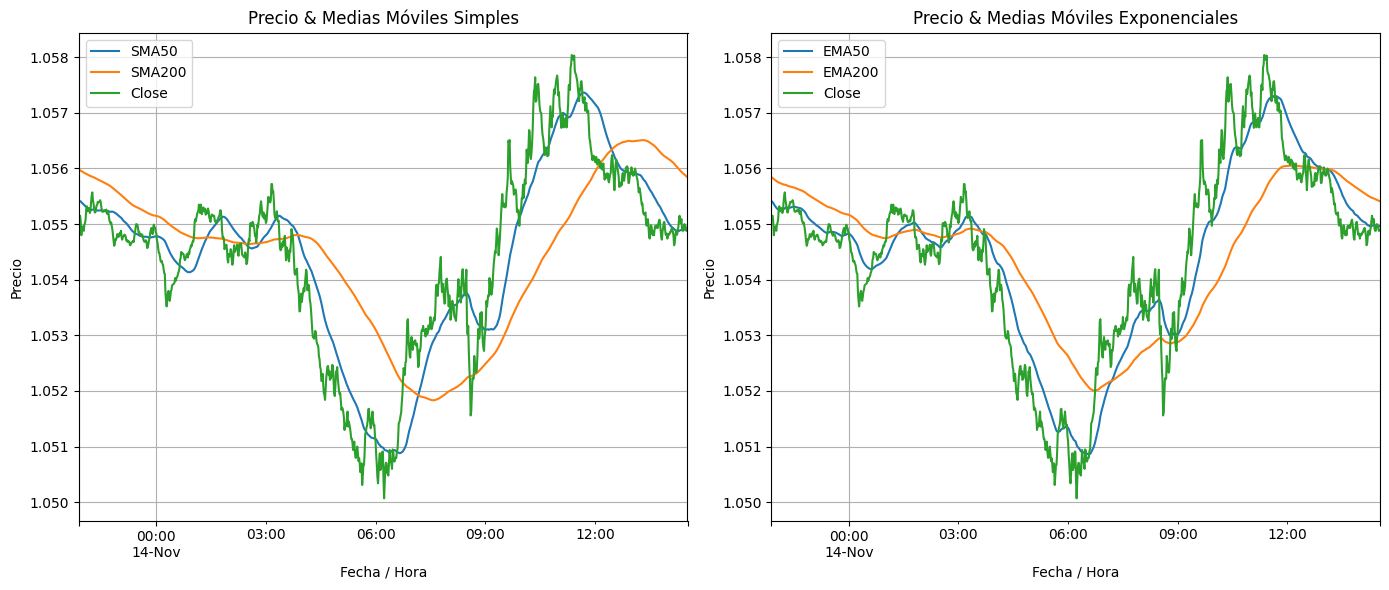

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Crear una figura con 1 fila y 2 columnas

# Gráfico 1: Precio & Medias Móviles Simples
df[['SMA50', 'SMA200', 'Close']][-1000:].plot(ax=axes[0], grid=True, title='Precio & Medias Móviles Simples')
axes[0].set_xlabel('Fecha / Hora')
axes[0].set_ylabel('Precio')

# Gráfico 2: Precio & Medias Móviles Exponenciales
df[['EMA50', 'EMA200', 'Close']][-1000:].plot(ax=axes[1], grid=True, title='Precio & Medias Móviles Exponenciales')
axes[1].set_xlabel('Fecha / Hora')
axes[1].set_ylabel('Precio')

# Ajustar el diseño para que no se solapen los gráficos
plt.tight_layout()
plt.show()


##### 1.5.- Cálculo de las señales de entrada utilizando la estrategía Golden Cross

- Es una de las señales de análisis técnico más conocidas para identificar tendencias alcistas en el mercado. Es una estrategia simple que se basa en el cruce de dos medias móviles: una de corto plazo y otra de largo plazo.
- El Golden Cross ocurre cuando una media móvil de corto plazo cruza por encima de una media móvil de largo plazo. 
- El cruce indica que la tendencia de corto plazo está ganando fuerza, lo cual sugiere que podría comenzar una tendencia alcista. 

**¿Cómo Funciona la Estrategia de Golden Cross?**

1. Identificar la Señal de Compra (Golden Cross):
    - La señal de compra ocurre cuando la media de 50 periodos cruza hacia arriba la de 200. 
    - Este cruce indica que la tendencia de corto plazo está ganando impulso alcista.
    - Se abre una posición de compra en el momento del cruce.
2. Mantener la Posición:
    - Después del cruce, se mantiene la posición mientras la media de 50 permanezca por encima de la de 200
    - Esto indica que la tendencia alcista se mantiene.
3. Identificar la Señal de Venta (con una Death Cross, opcional):
    - La señal de venta ocurre cuando la media de 50 cruza hacia abajo la de 200 (llamada Death Cross o Cruz de la Muerte)
    - Indica una posible reversión hacia una tendencia bajista.
    - Se usará este cruce bajista para cerrar la posición 
    - Se puede utilizar incluso para abrir una posición en corto.

**En la estrategia de Golden Cross, la idea es que siempre estás en una posición (comprado o vendido), dependiendo de la relación entre las medias móviles**




In [ ]:
# 1. Identificar la Señal de Compra (Golden Cross):
#     - La señal de compra ocurre cuando la media de 50 periodos cruza hacia arriba la de 200. 
df['Senial_SMA'] = np.where(df['SMA50']>df['SMA200'], 1, 0)
df['Senial_EMA'] = np.where(df['EMA50']>df['EMA200'], 1, 0)

df['Retorno_Mercado'] = df.Close - df.Close.shift(1) 

df['Retorno_SMA'] = df['Retorno_Mercado'] * df['Senial_SMA'].shift(1)
df['Retorno_EMA'] = df['Retorno_Mercado'] * df['Senial_EMA'].shift(1)

Retorno acumulado SMA -0.00961000000000034
Retorno acumulado EMA -0.009540000000001214
Retorno acumulado Mercado -0.03357999999999994


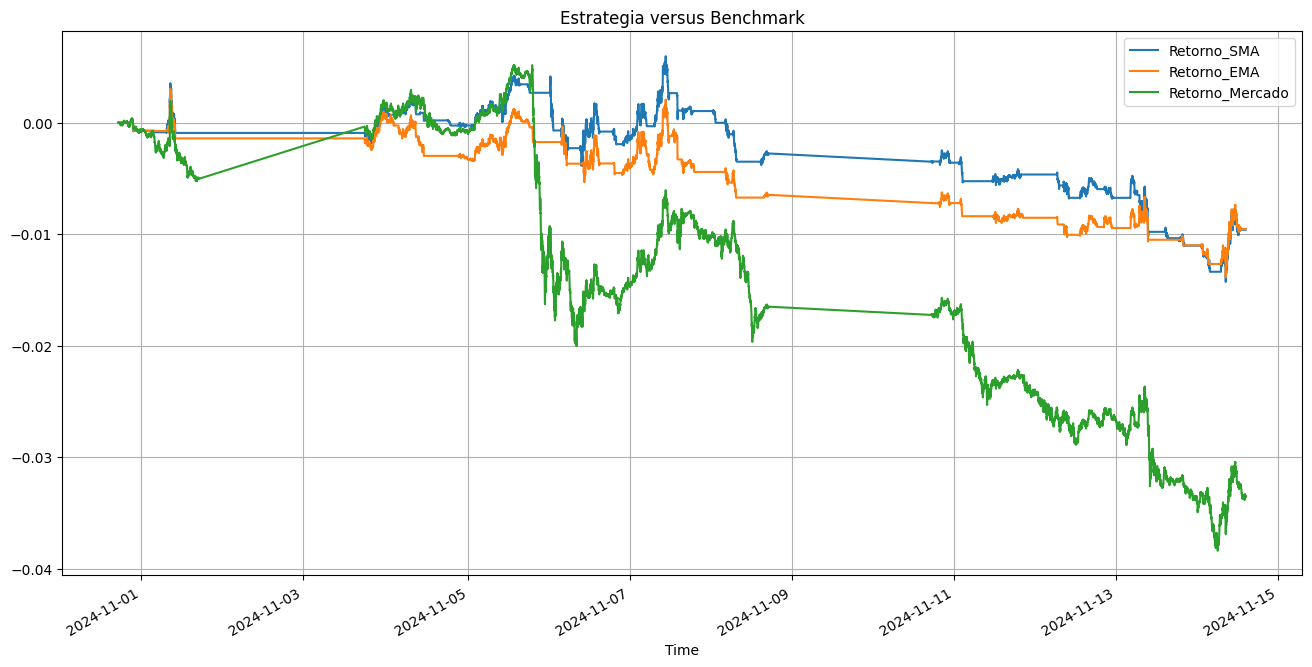

In [ ]:
# Gráfico 1: Precio & Medias Móviles Simples

# .cumsum() da una serie acumulativa que muestra cómo se acumula la suma en cada fila (una columna de valores).
df[['Retorno_SMA', 'Retorno_EMA', 'Retorno_Mercado']].cumsum().plot(grid = True,
                                                         title ='Estrategia versus Benchmark',
                                                         figsize =(16,8))
axes[0].set_xlabel('Fecha / Hora')
axes[0].set_ylabel('Retono Acumulado (puntos básicos)')

# .sum() devuevle un escalar con la suma de todos los valores de una columna
print('Retorno acumulado SMA', df['Retorno_SMA'].sum())
print('Retorno acumulado EMA', df['Retorno_EMA'].sum())
print('Retorno acumulado Mercado', df['Retorno_Mercado'].sum())

In [ ]:
# Desconecta nuestra aplicación de IB. 
ib.disconnect()